### Explanation
Abbiamo un dataset clinico longitudinale sul Parkinson. Ogni paziente ha:
1. più visite
2. biomarcatori vocali
3. età
4. punteggi clinici (motor_UPDRS)

La domanda è: posso usare le visite passate per prevedere la severità futura? Questo è un problema di regressione **temporale longitudinale**

stiamo modellando una funzione: $f(X_{t-5},...,X_{t}) = y_{t}$
dove $X_{t}$ sono feature cliniche alla visita $t$, $y_{t}=$ motor_UPDRS alla visita $t$.

Non stiamo facendo classificazione nè cross-sectional prediction, stiamo facendo una **sequence-to-one regression**.

Innanzitutto dobbiamo trasformare dati cross-sectional in dati sequenziali: 

- il dataset originale ha una forma del tipo $|paziente|visita|feature|target$
- il dataset per GRU invece: $X \in R^{N \times T \times D}$, dove N=numero sequenze, T=lunghezza finestra (6) e D=numero feature (20) e $y \in R^{N}$

In questo notebook:
1. Ordiniamo per paziente e tempo, perchè una sequenza deve rispettare l'ordine temporale, se non ordino distruggo la dinamica
2. creiamo sliding windows: se ad esempio abbiamo un paziente con 8 visite: v1, v2, v3, v4, v5, v6, v7, v8, con T=6 otteniamo
   - (v1-v6) $\rightarrow$ predico v6
   - (v2-v7) $\rightarrow$ predico v7
   - (v3-v8) $\rightarrow$ predico v8
   non solo la prima perchè vogliamo massimizzare i dati
3. perchè target=ultiimo punto? perchè stiamo facendo predizione dello stato corrente usando la storia recente, non stiamo predicendo il futuro oltre la finestra, stiamo stimando la severità attuale data la traiettoria recente
4. Perchè split per paziente? se metto visite dello stesso paziente in train e test, il modello impara caratteristiche idiosincratiche di quel soggetto, non sto testando generalizzazione clinica, sto testando memoria, quindi lo split per soggetto serve per stimare performance su nuovi pazienti.
5. Normalizziamo perchè le feature vocali hanno scale diverse, se non normalizzo la GRU privilegia feature con varianza maggiore, il training diventa instabile (normalizzazione=condizionamento numerico del problema di ottimizzazione).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
os.chdir("/Users/pasqualinodipilla/multimodal-synthetic-biomedical")
os.getcwd()

'/Users/pasqualinodipilla/multimodal-synthetic-biomedical'

In [23]:
df = pd.read_csv("data/parkinson/parkinsons_updrs.data")
df.columns = [c.strip() for c in df.columns]

df.head(20)

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361
5,1,72,0,40.6520,29.435,36.870,0.00353,0.000023,0.00119,0.00159,...,0.214,0.01006,0.01337,0.02263,0.03019,0.009438,22.946,0.53949,0.57243,0.19500
6,1,72,0,47.6490,29.682,37.363,0.00422,0.000024,0.00212,0.00221,...,0.445,0.02376,0.02621,0.03488,0.07128,0.013260,22.506,0.49250,0.54779,0.17563
7,1,72,0,54.6400,29.928,37.857,0.00476,0.000025,0.00226,0.00259,...,0.212,0.00979,0.01462,0.01911,0.02937,0.027969,22.929,0.47712,0.54234,0.23844
8,1,72,0,61.6690,30.177,38.353,0.00432,0.000029,0.00156,0.00207,...,0.371,0.01774,0.02134,0.03451,0.05323,0.013381,22.078,0.51563,0.61864,0.20037
9,1,72,0,68.6880,30.424,38.849,0.00496,0.000027,0.00258,0.00253,...,0.310,0.02030,0.01970,0.02569,0.06089,0.018021,22.606,0.50032,0.58673,0.20117


In [5]:
df.shape, df["subject#"].nunique()

((5875, 22), 42)

In [6]:
#quante visite ha ogni paziente?
visits = df.groupby("subject#").size().sort_values()
visits.describe()

count     42.000000
mean     139.880952
std       15.542550
min      101.000000
25%      130.000000
50%      141.000000
75%      149.750000
max      168.000000
dtype: float64

In [7]:
visits.head(10), visits.tail(10)

(subject#
 32    101
 12    107
 22    112
 13    112
 21    123
 18    126
 30    126
 19    129
 36    129
 27    129
 dtype: int64,
 subject#
 42    150
 9     152
 24    156
 6     156
 5     156
 34    161
 7     161
 41    165
 35    165
 29    168
 dtype: int64)

In [8]:
#scelgo un paziente e lo ordino nel tempo
PATIENT_COL = "subject#"
TIME_COL = "age"
TARGET_COL = "motor_UPDRS"

patient_id = df["subject#"].unique()[0]
p=df[df[PATIENT_COL] == patient_id].sort_values(TIME_COL).reset_index(drop=True)

p[[TIME_COL, TARGET_COL]].head(10)

,age,motor_UPDRS
0,72,28.199
1,72,35.510
2,72,35.976
3,72,36.443
4,72,36.978
5,72,28.199
6,72,28.447
7,72,35.043
8,72,28.695
9,72,29.188


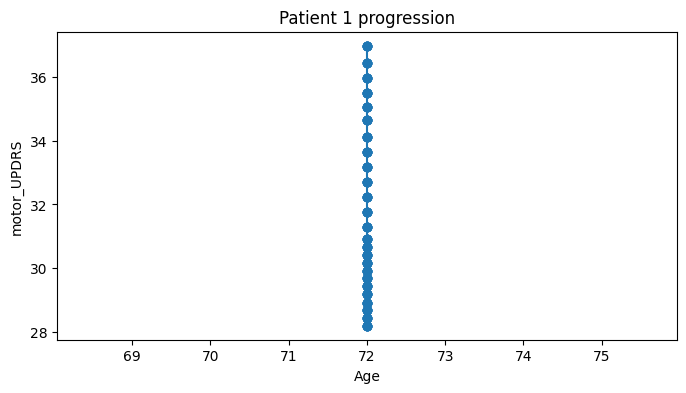

In [ ]:
#visualizzo la progressione -> progressione longitudinale
plt.figure(figsize=(8,4))
plt.plot(p[TIME_COL], p[TARGET_COL], marker="o")
plt.xlabel("Age")
plt.ylabel("motor_UPDRS")
plt.title(f"Patient {patient_id} progression")
plt.show()

In [11]:
#creo una finestra T=6 a mano
SEQ_LEN = 6

window = p.iloc[:SEQ_LEN]
window[[TIME_COL, TARGET_COL]]

,age,motor_UPDRS
0,72,28.199
1,72,35.510
2,72,35.976
3,72,36.443
4,72,36.978
5,72,28.199


In [12]:
window[TARGET_COL].iloc[-1]

np.float64(28.199)

In [13]:
#sliding windows: quante sequenze crea questo paziente?
num_visits = len(p)
num_sequences = max(0, num_visits - SEQ_LEN + 1)
num_visits, num_sequences

(149, 144)

In [14]:
#definisco le feature
exclude = {PATIENT_COL, TARGET_COL}
feature_cols = [c for c in df.columns if c not in exclude]

len(feature_cols), feature_cols[:10]

(20,
 ['age',
  'sex',
  'test_time',
  'total_UPDRS',
  'Jitter(%)',
  'Jitter(Abs)',
  'Jitter:RAP',
  'Jitter:PPQ5',
  'Jitter:DDP',
  'Shimmer'])

In [15]:
#costruisco sequenze per questo paziente
Xg = p[feature_cols].to_numpy(dtype=np.float32)
yg = p[TARGET_COL].to_numpy(dtype=np.float32)

X_list, y_list = [], []
for start in range(0, len(p)-SEQ_LEN+1):
    end = start+SEQ_LEN
    X_list.append(Xg[start:end])
    y_list.append(yg[end-1])

X_p = np.stack(X_list) #(n_seq_patient, 6, 20)
y_p = np.array(y_list)

X_p.shape, y_p.shape

((144, 6, 20), (144,))

In [16]:
#split per paziente (senza leakage)
from sklearn.model_selection import train_test_split

unique_pids = df[PATIENT_COL].unique()
train_pids, test_pids = train_test_split(unique_pids, test_size=0.2, random_state=42)

train_pids[:5], test_pids[:5], len(train_pids), len(test_pids)

(array([ 7, 28, 13, 18, 10]), array([26, 14,  9, 27,  5]), 33, 9)

In [17]:
set(train_pids).intersection(set(test_pids))

set()

In [18]:
#carico l'npz prodotto dallo script e confronto
data = np.load("data/parkinson/processed/parkinson_T6_motor_UPDRS.npz", allow_pickle=True)

X_train = data["X_train"]
X_test = data["X_test"]
y_train = data["y_train"]
y_test = data["y_test"]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4475, 6, 20), (1190, 6, 20), (4475,), (1190,))

In [19]:
#verifico numero pazienti:
len(np.unique(data["pid_train"])), len(np.unique(data["pid_test"]))

(33, 9)

In [20]:
#normalizzazione (prima/dopo): nei file salvati abbiamo media 0 e std 1 circa.
Xtr_flat = X_train.reshape(-1, X_train.shape[-1])
Xtr_flat.mean(axis=0)[:5], Xtr_flat.std(axis=0)[:5]

(array([ 7.7860983e-07,  5.7509446e-06,  1.3394951e-08, -3.6210110e-06,
         3.9201652e-07], dtype=float32),
 array([0.9999335 , 0.99998254, 0.9999902 , 1.0000148 , 0.9999983 ],
       dtype=float32))